In [1]:
import pandas as pd
import numpy as np
import scipy 
import matplotlib.pyplot as plt
import seaborn as sns 
import warnings 
import os
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Setting the working directory
os.chdir(r'../')

# Pandas option:
pd.set_option('max_colwidth',40)  # This allows us to see the data upto 40 characters per each column

pd.options.display.max_columns = None   # This allows us to see all the columns without collapsing 


# The below code is for for showing all expressions, not just the result of the last expression
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

# Table styles, this below code is for decorating the dataframe no functional use.
table_styles = {
        'cerulean_palette' : [
        dict(selector="th", props=[("color", "#FFFFFF"), ("background", "#004D80"), ("text-transform", "capitalize")]),
        dict(selector="td", props=[("color", "#333333")]),
        dict(selector="table", props=[("font-family", 'Arial'), ("border-collapse", "collapse")]),
        dict(selector='tr:nth-child(even)', props=[('background', '#D3EEFF')]),
        dict(selector='tr:nth-child(odd)', props=[('background', '#FFFFFF')]),
        dict(selector="th", props=[("border", "1px solid #0070BA")]),
        dict(selector="td", props=[("border", "1px solid #0070BA")]),
        dict(selector="tr:hover", props=[("background", "#80D0FF")])
    ]
}

# Filtering all the warnings:
warnings.filterwarnings('ignore')

In [2]:
df=pd.read_csv('../ntu_sd6101_team_project_data/zomato.csv', na_values=['-','',' ','NEW','[]'])
df['rate'] = df['rate'].replace('-', pd.NA)
df['rate'] = df['rate'].str.replace('/5','')
df['rate'] = df['rate'].astype('float')
df['votes'] = df['votes'].astype('int')
df['approx_cost(for two people)'] = df['approx_cost(for two people)'].str.replace(',','')
df['approx_cost(for two people)'] = df['approx_cost(for two people)'].astype('float')
df['approx_cost'] = df['approx_cost(for two people)']/2
df.drop(columns='approx_cost(for two people)', inplace=True)
df.head()

,url,address,name,online_order,book_table,rate,votes,phone,location,rest_type,dish_liked,cuisines,reviews_list,menu_item,listed_in(type),listed_in(city),approx_cost
0,https://www.zomato.com/bangalore/jal...,"942, 21st Main Road, 2nd Stage, Bana...",Jalsa,Yes,Yes,4.1,775,080 42297555\r\n+91 9743772233,Banashankari,Casual Dining,"Pasta, Lunch Buffet, Masala Papad, P...","North Indian, Mughlai, Chinese","[('Rated 4.0', 'RATED\n A beautiful...",NaN,Buffet,Banashankari,400.0
1,https://www.zomato.com/bangalore/spi...,"2nd Floor, 80 Feet Road, Near Big Ba...",Spice Elephant,Yes,No,4.1,787,080 41714161,Banashankari,Casual Dining,"Momos, Lunch Buffet, Chocolate Nirva...","Chinese, North Indian, Thai","[('Rated 4.0', 'RATED\n Had been he...",NaN,Buffet,Banashankari,400.0
2,https://www.zomato.com/SanchurroBang...,"1112, Next to KIMS Medical College, ...",San Churro Cafe,Yes,No,3.8,918,+91 9663487993,Banashankari,"Cafe, Casual Dining","Churros, Cannelloni, Minestrone Soup...","Cafe, Mexican, Italian","[('Rated 3.0', ""RATED\n Ambience is...",NaN,Buffet,Banashankari,400.0
3,https://www.zomato.com/bangalore/add...,"1st Floor, Annakuteera, 3rd Stage, B...",Addhuri Udupi Bhojana,No,No,3.7,88,+91 9620009302,Banashankari,Quick Bites,Masala Dosa,"South Indian, North Indian","[('Rated 4.0', ""RATED\n Great food ...",NaN,Buffet,Banashankari,150.0
4,https://www.zomato.com/bangalore/gra...,"10, 3rd Floor, Lakshmi Associates, G...",Grand Village,No,No,3.8,166,+91 8026612447\r\n+91 9901210005,Basavanagudi,Casual Dining,"Panipuri, Gol Gappe","North Indian, Rajasthani","[('Rated 4.0', 'RATED\n Very good r...",NaN,Buffet,Banashankari,300.0


In [3]:
df_sample = df.sample(1000, random_state=42)
df_sample.shape

(1000, 17)

In [5]:
df_sample.to_csv('data/zomato_.csv', index=False)

In [16]:
cuisine_set = set()
for i in df['cuisines']:
    for j in str(i).split(','):
        cuisine_set.add(j.strip())
len(cuisine_set)

108

In [32]:
cuisine_df = df.loc[:,['cuisines']].copy()
for i in cuisine_set:
    cuisine_df['has'+i] = 0

for i in cuisine_set:
    for j in range(cuisine_df.shape[0]):
        offer = str(cuisine_df.iloc[j, 0])
        if i in offer:
            cuisine_df.loc[j, 'has'+i] = 1

cuisine_df.drop(columns='cuisines', inplace=True)
cuisine_df.shape

(51717, 108)

In [61]:
cuisine_df.columns

Index(['hasJapanese', 'hasVietnamese', 'hasKashmiri', 'hasParsi', 'hasSindhi',
       'hasStreet Food', 'hasBiryani', 'hasBurger', 'hasCoffee', 'hasPaan',
       ...
       'hasIce Cream', 'hasNepalese', 'hasGreek', 'hasCafe', 'hasFinger Food',
       'hasCharcoal Chicken', 'hasBritish', 'hasHot dogs', 'hasKerala',
       'hasJuices'],
      dtype='object', length=108)

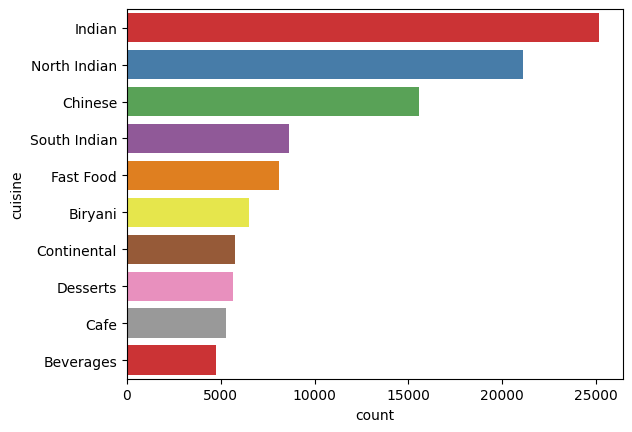

In [69]:
cuisine_set = set()
for i in df['cuisines']:
    for j in str(i).split(','):
        cuisine_set.add(j.strip())

cuisine_df = df.loc[:,['cuisines']].copy()
for i in cuisine_set:
    cuisine_df['has'+i] = 0

for i in cuisine_set:
    for j in range(cuisine_df.shape[0]):
        offer = str(cuisine_df.iloc[j, 0])
        if i in offer:
            cuisine_df.loc[j, 'has'+i] = 1

cuisine_df.drop(columns='cuisines', inplace=True)

count_df = []
for col in cuisine_df.columns:
    num = cuisine_df[col].sum()
    col = col.replace('has','')
    dict1 = {'cuisine':col, 'count':num}
    count_df.append(dict1)

count_df = pd.DataFrame(count_df)
count_df = count_df.sort_values(by='count', ascending=False).head(10)
ax = sns.barplot(y='cuisine', x='count', data=count_df, palette="Set1")

In [33]:
# PCA
pca = PCA(n_components=10)
pca.fit(cuisine_df)
pca.explained_variance_ratio_

PCA(n_components=10)

array([0.24666152, 0.07243824, 0.06428209, 0.06005346, 0.05573334,
       0.04976791, 0.03715328, 0.032372  , 0.0306575 , 0.02369527])

In [34]:
PCA_df = pd.DataFrame(pca.transform(cuisine_df), columns=['PCA'+str(i) for i in range(1,11)])
PCA_df.head()

,PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7,PCA8,PCA9,PCA10
0,0.985105,0.448982,-0.048565,0.130000,-0.131844,-0.209408,-0.076421,-0.106691,-0.136698,0.015881
1,0.952800,0.520505,-0.070725,0.047005,-0.063203,-0.225619,-0.133646,-0.112842,-0.093994,0.013465
2,-0.814905,0.191776,0.578300,-0.207304,0.188194,0.354841,0.136784,-0.149148,-0.756825,0.365561
3,0.786391,-0.778710,0.130406,-0.195094,0.262061,-0.092127,-0.040149,0.005160,-0.055745,0.020137
4,0.589991,-0.315202,0.355961,0.333671,-0.202979,-0.147844,-0.229681,-0.133886,-0.089670,0.007350


KMeans(n_clusters=1)

KMeans(n_clusters=2)

KMeans(n_clusters=3)

KMeans(n_clusters=4)

KMeans(n_clusters=5)

KMeans(n_clusters=6)

KMeans(n_clusters=7)

KMeans()

KMeans(n_clusters=9)

KMeans(n_clusters=10)

KMeans(n_clusters=11)

KMeans(n_clusters=12)

KMeans(n_clusters=13)

KMeans(n_clusters=14)

KMeans(n_clusters=15)

KMeans(n_clusters=16)

KMeans(n_clusters=17)

KMeans(n_clusters=18)

KMeans(n_clusters=19)

KMeans(n_clusters=20)

([<matplotlib.axis.XTick at 0x16ad47d90>,
 [Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9'),
  Text(10, 0, '10'),
  Text(11, 0, '11'),
  Text(12, 0, '12'),
  Text(13, 0, '13'),
  Text(14, 0, '14'),
  Text(15, 0, '15'),
  Text(16, 0, '16'),
  Text(17, 0, '17'),
  Text(18, 0, '18'),
  Text(19, 0, '19'),
  Text(20, 0, '20')])

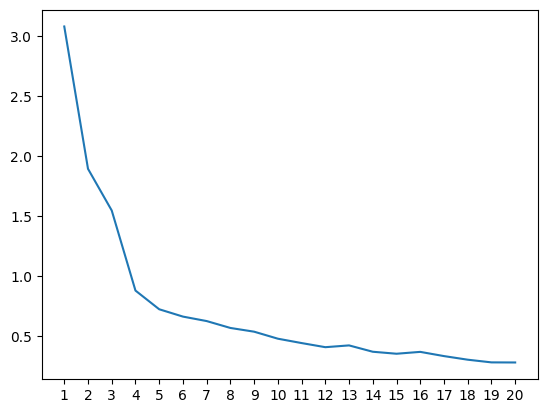

In [46]:
# test different number of clusters
inertia = []
for i in range(1, 21):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(PCA_df)
    inertia.append(kmeans.inertia_/PCA_df.shape[0])
plt.plot(range(1, 21), inertia)
plt.xticks(range(1, 21))
plt.show()

In [47]:
best_k = 5
kmeans = KMeans(n_clusters=best_k)
kmeans.fit(PCA_df)
PCA_df['cluster'] = kmeans.predict(PCA_df)

KMeans(n_clusters=5)

In [50]:
# TSNE
tsne = TSNE(n_components=2)
tsne.fit(cuisine_df)
tsne_df = pd.DataFrame(tsne.fit_transform(cuisine_df), columns=['x', 'y'])
tsne_df.head()

TSNE()

,x,y
0,59.041382,66.930321
1,24.078350,54.296234
2,-84.853951,12.765432
3,19.774544,-61.733646
4,28.484814,-82.371368


In [56]:
std = StandardScaler()
tsne_df = pd.DataFrame(std.fit_transform(tsne_df.loc[:,['x','y']]), columns=['x', 'y'])

KMeans(n_clusters=1)

KMeans(n_clusters=2)

KMeans(n_clusters=3)

KMeans(n_clusters=4)

KMeans(n_clusters=5)

KMeans(n_clusters=6)

KMeans(n_clusters=7)

KMeans()

KMeans(n_clusters=9)

KMeans(n_clusters=10)

KMeans(n_clusters=11)

KMeans(n_clusters=12)

KMeans(n_clusters=13)

KMeans(n_clusters=14)

KMeans(n_clusters=15)

KMeans(n_clusters=16)

KMeans(n_clusters=17)

KMeans(n_clusters=18)

KMeans(n_clusters=19)

KMeans(n_clusters=20)

([<matplotlib.axis.XTick at 0x33796c0a0>,
 [Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9'),
  Text(10, 0, '10'),
  Text(11, 0, '11'),
  Text(12, 0, '12'),
  Text(13, 0, '13'),
  Text(14, 0, '14'),
  Text(15, 0, '15'),
  Text(16, 0, '16'),
  Text(17, 0, '17'),
  Text(18, 0, '18'),
  Text(19, 0, '19'),
  Text(20, 0, '20')])

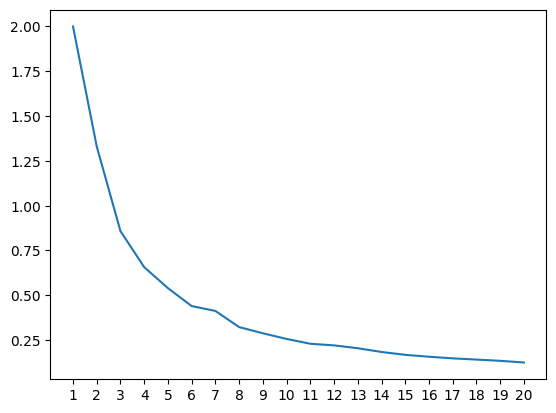

In [57]:
# test different number of clusters
inertia = []
for i in range(1, 21):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(tsne_df)
    inertia.append(kmeans.inertia_/tsne_df.shape[0])
plt.plot(range(1, 21), inertia)
plt.xticks(range(1, 21))
plt.show()

In [58]:
best_k = 6
kmeans = KMeans(n_clusters=best_k)
kmeans.fit(tsne_df)
tsne_df['cluster'] = kmeans.predict(tsne_df)

KMeans(n_clusters=6)

<Figure size 1000x600 with 0 Axes>

<Axes: xlabel='x', ylabel='y'>

Text(0.5, 1.0, 'TSNE')

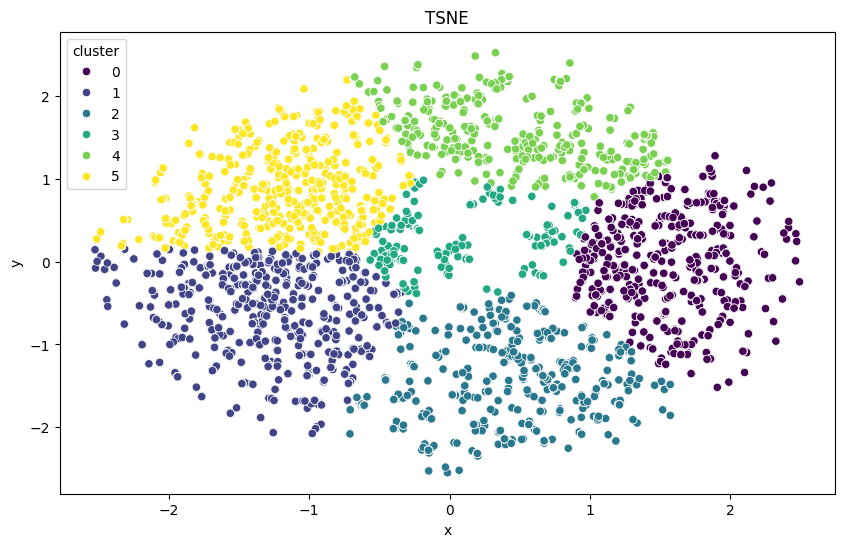

In [59]:
# Visualizing the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='x', y='y', data=tsne_df, hue='cluster', palette='viridis')
plt.title('TSNE')